<a href="https://colab.research.google.com/github/gani0325/2022/blob/main/kaggle/chest_x_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022-01-29

###  Chest X-Ray - kaggle
### https://www.kaggle.com/search 참고
### https://velog.io/@hwanython/%ED%8F%90%EC%95%94-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0 참고

### 1. 라이브러리 import 및 데이터 load

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# 데이터 로드 빠르게
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-ray 이미지 사이즈
IMAGE_SIZE = [180, 180]

* 데이터 경로

In [ ]:
root_path = os.getcwd() + '\\'
train_path = root_path + "chest_xray\\train\\*\\*"
val_path = root_path + "chest_xray\\val\\*\\*"
test_path = root_path + "chest_xray\\test\\*\\*"

In [ ]:
train_path

'c:\\Users\\82106\\OneDrive - Microsoft 365\\문서\\가은대학\\2022\\gani_project\\Kaggle\\Chest_x-ray\\chest_xray\\train\\*\\*'

In [ ]:
BATCH_SIZE = 30     # 정한 만큼의 배치
EPOCHS = 50

#### 2. 데이터 준비

In [ ]:
train_data = tf.io.gfile.glob(train_path)
test_data = tf.io.gfile.glob(test_path)
val_data = tf.io.gfile.glob(val_path)

print(len(train_data))
print(len(test_data))
print(len(val_data))

5216
624
16


* val 너무 작으니 train 과 val 합치고 다시 8:2

In [ ]:
train_val_sum = tf.io.gfile.glob(train_path)
train_val_sum.extend(tf.io.gfile.glob(val_path))

# 8:2
train_size = math.floor(len(train_val_sum)*0.8)
random.shuffle(train_val_sum)   # shuffle : 고정 크기 버퍼를 유지하고 뮤작위로 균일
train = train_val_sum[:train_size]
val = train_val_sum[train_size:]

print(len(train))
print(len(val))

4185
1047


* 폐렴 3108개, 폐렴 아닌 것 1077개

In [ ]:
normal = len([filename for filename in train if "NORMAL" in filename])
print(f"normal image count in train set : {normal}")

pneumonia = len([filename for filename in train if "PNEUMONIA" in filename])
print(f"pneumonia image count in train set : {pneumonia}")

normal image count in train set : 1071
pneumonia image count in train set : 3114


* tf.data.Dataset.from_tensor_slices 함수는 tf.data.Dataset 를 생성하는 함수

In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train)
val_list_ds = tf.data.Dataset.from_tensor_slices(val)

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


* 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터

In [ ]:
# 파일 경로의 끝에서 두번째 부분으로 양성과 음성을 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

* 이미지 사이즈 줄이기

In [ ]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 [180, 180] 수정
    return img

* 이미지와 라벨 읽기

In [ ]:
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

* train 데이터 셋과 validation 데이터 셋 만들기

In [ ]:
# 빠르게 데이터 처리
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

* 이미지 확인

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


* test 도 동일하게!

In [ ]:
test_list_ds = tf.data.Dataset.list_files(test_path)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

for image, label in test_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
print(TEST_IMAGE_COUNT)

Image shape:  (30, 180, 180, 3)
Label:  [ True  True  True  True  True False  True  True False False  True False
  True False  True  True False False False False  True  True  True  True
  True  True  True False  True  True]
624


* data 좀더 효율적으로

In [ ]:
# random_flip_left_right : 랜덤하게 좌우를 반전
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    return image,label

In [ ]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    # shuffle : 고정 크기 버퍼를 유지하고 뮤작위로 균일하게 다음 요소를 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat : 여러 번 데이터 부르기
    ds = ds.repeat()
    # batch : 정한 만큼의 배치
    ds = ds.batch(BATCH_SIZE)
    # prefech : GPU와 CPU를 효율적으로 사용
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### 3. 데이터 시각화

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줌
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):     # BATCH_SIZE = 30
        ax = plt.subplot(5,math.ceil(BATCH_SIZE / 5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

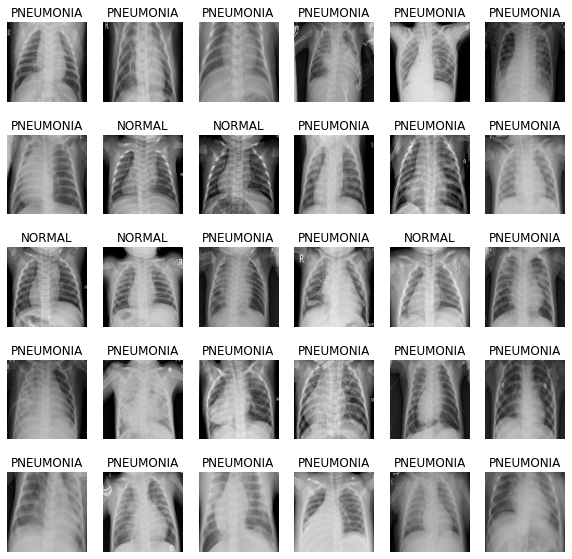

In [ ]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

#### 4. CNN 모델링

###### CNN은 Convolution Layer와 Max Pooling 레이어를 반복적으로 stack을 쌓는 특징 추출(Feature Extraction) 부분과 Fully Connected Layer를 구성하고 마지막 출력층에 Softmax를 적용한 분류 부분으로 나뉩니다.

* convolution block

1) conv 2 번
2) batch normal 로 과적합 방지
3) max pooling

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

* dense block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

* 전체 모델

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### 5. 데이터 불균형 처리

In [ ]:
weight_for_0 = (1 / normal)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / pneumonia)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


#### 6. 모델 훈련

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
from keras.callbacks import EarlyStopping
# 최고의 정확도를 가질때 멈춰주는 함수 추가
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=10, callbacks=[es],
    validation_data = val_ds,
    validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
    class_weight = class_weight,
)

Epoch 1/10
139/139 [==============================] - 269s 2s/step - loss: 0.3034 - accuracy: 0.8652 - precision: 0.9683 - recall: 0.8466 - val_loss: 0.6460 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/10
139/139 [==============================] - 224s 2s/step - loss: 0.2097 - accuracy: 0.9209 - precision: 0.9757 - recall: 0.9166 - val_loss: 0.8901 - val_accuracy: 0.7343 - val_precision: 0.7343 - val_recall: 1.0000
Epoch 3/10
139/139 [==============================] - 215s 2s/step - loss: 0.1774 - accuracy: 0.9357 - precision: 0.9768 - recall: 0.9358 - val_loss: 1.3695 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/10
139/139 [==============================] - 209s 2s/step - loss: 0.1444 - accuracy: 0.9487 - precision: 0.9823 - recall: 0.9480 - val_loss: 1.5471 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 5/10
139/139 [==============================] - 204s 1s/step - loss: 0.1458 - accuracy: 0.9489

#### 7. 시각화

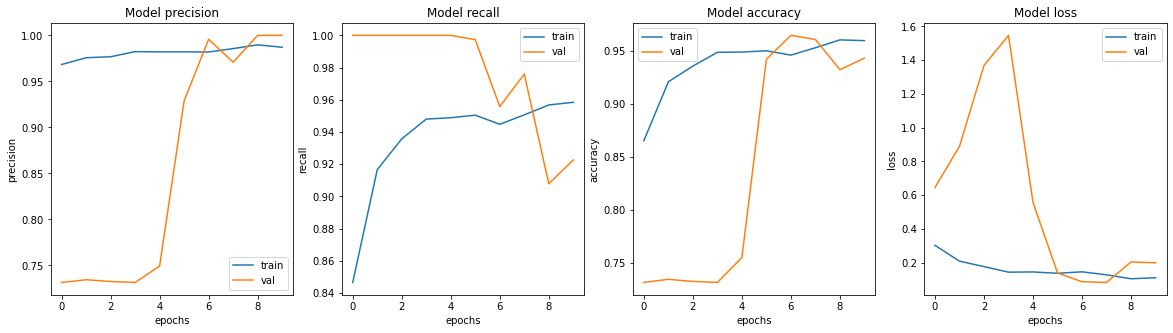

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

* test 데이터로 모델 평가

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://miro.medium.com/proxy/1*pOtBHai4jFd-ujaNXPilRg.png")

* Precision ( 정밀도 ) ex) 확진자로 분류된 사람들 중 실제 양성 시미닐 확률
* Recall ( 재현율 ) ex) 실제로 양성인 시민을 확진자로 분류할 확률

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

21/21 [==============================] - 15s 692ms/step - loss: 0.3945 - accuracy: 0.8686 - precision: 0.8632 - recall: 0.9385
Loss: 0.3944617807865143,
Accuracy: 0.8685897588729858,
Precision: 0.8632075190544128,
Recall: 0.9384615421295166
